# Explaining predictions

Feature importance methods allow us to identify features which have proven useful in aggregate. We can also try to identify features that were important for a **specific example**. This is particularly useful in our case, since we'd like to use a model to make recommendations for a specific given input. Additionally, this method does not require the use of a model that exposes feature importance, and can thus work on black-box models. Here, we'll use a black box explainer called [LIME](https://github.com/marcotcr/lime).

We first load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.externals import joblib
import random
from collections import defaultdict
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series, 
    get_feature_vector_and_label
)
from ml_editor.model_v1 import get_model_probabilities_for_input_texts
from lime.lime_text import LimeTextExplainer
random.seed(40)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

Then, we add features and split the data.

In [2]:
df = add_text_features_to_df(df.loc[df["is_question"]].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

We load the pretrained model and vectorizer.

In [3]:
model_path = Path("../models/model_1.pkl")
clf = joblib.load(model_path) 
vectorizer_path = Path("../models/vectorizer_1.pkl")
vectorizer = joblib.load(vectorizer_path) 

We vectorize the text and get features ready for our model

In [4]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer)

features = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]
X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

Now, we use LIME to make functions that will explain a model's predictions for a **specific example**.

In [5]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, get_model_probabilities_for_input_texts, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Low score","High score"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

Here, we are particularly interested in finding which type of content in the question our classifier relies on. We can do so by visualizing explanations for specific examples, as shown for two questions below.

In [6]:
visualize_one_exp(list(test_df["full_text"]), list(y_test), 7)

Index: 7
True class: High score


In [7]:
visualize_one_exp(list(test_df["full_text"]), list(y_test), 12)

Index: 12
True class: High score


It would be valuable to get a sense for which words influence our model in many examples. To do so, we can sample multiple examples from the dataset, and average importances.

Sampling more examples allows for a better estimate of the global word importance, but also takes longer. Below, I used 500 examples, which takes quite some time. Feel free to tweak this number.

In [8]:
def get_statistical_explanation(test_set, sample_size, model_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = model_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, model_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Low score',
    1: 'High score',
}
sorted_contributions = get_statistical_explanation(list(test_df["full_text"]), 500, get_model_probabilities_for_input_texts, label_to_text)

Now that we've run the explainer, I'll plot the most important words in aggregate and see if they seem like good words for the model to focus on.

In [9]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Low score', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('High score', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

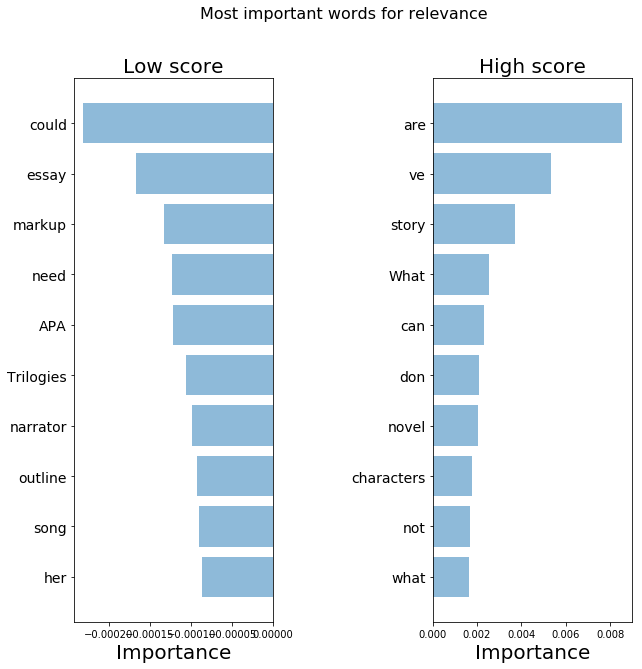

In [10]:
top_words = sorted_contributions['High score']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['High score']['supporters'][:10].tolist()
bottom_words = sorted_contributions['High score']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['High score']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

These do not seem like features that would be relevant to a good question being asked. Words predictive of high score questions are simply the most common English words. Words predictive of a low score question seem to be about the type of writing (essay, Trilogies) and may be indicative of stackoverflow posting guidelines.

Regardless, this result may be a sign that our model is overfitting, or that our text vectorization process is not surfacing the most useful information.